In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from CalcularRotaShapefile import CalcularRotaShapefile
import networkx as nx
import matplotlib.pyplot as plt
from shapely.strtree import STRtree
import numpy as np
from scipy.spatial import KDTree


In [42]:
gdf = gpd.read_file("MapaTrechoCidade/MapaTrechoCidadeLine.shp")
df = pd.read_csv("EquipamentoPublicoDados.csv", sep=",")
shap = CalcularRotaShapefile("MapaTrechoCidade/MapaTrechoCidadeLine.shp")
gdf

,codigoTrec,codigoLogr,nomeLograd,viaMaoUnic,extensao,codigoTipo,nomeTipoHi,situacaoTr,nomeSituac,naoOficial,geometry
0,2507,2322,"""Rua Sem Nome""",0.0,115.05,NaN,None,1,Aberta,1,"LINESTRING (352579.85 7343498.813, 352686.634 ..."
1,3180,2542,"""Prolongamento Rua Edila Amazonina Rodrigues S...",0.0,41.16,NaN,None,1,Aberta,1,"LINESTRING (353407.977 7344765.584, 353394.499..."
2,5114,2545,"""Rua Marginal I do Canal Aclimação""",0.0,220.56,NaN,None,1,Aberta,1,"LINESTRING (346101.714 7342783.059, 346032.702..."
3,5227,2600,"""Rua Sem Nome III no loteamento Balneário Esme...",0.0,153.10,NaN,None,1,Aberta,1,"LINESTRING (344721.098 7342195.997, 344598.626..."
4,5228,2600,"""Rua Sem Nome III no loteamento Balneário Esme...",0.0,174.48,NaN,None,1,Aberta,1,"LINESTRING (344860.855 7342091.534, 344721.098..."
...,...,...,...,...,...,...,...,...,...,...,...
10369,20547,382,Rua Elydio Julio Baptista,0.0,17.42,NaN,None,1,Aberta,0,"LINESTRING (353744.852 7344766.947, 353731.961..."
10370,20548,2705,Viela Viela 04 do Núcleo Jardim Marília,NaN,24.36,NaN,None,1,Aberta,0,"LINESTRING (353719.502 7344786.491, 353727.767..."
10371,20549,382,Rua Elydio Julio Baptista,0.0,37.16,NaN,None,1,Aberta,0,"LINESTRING (353727.767 7344763.573, 353701.334..."
10372,20550,2706,Viela Viela 05 do Núcleo Jardim Marília,NaN,22.77,NaN,None,1,Aberta,0,"LINESTRING (353625.33 7344785.939, 353617.012 ..."


Ruas duplicadas: 40
Número de componentes conectados: 146
O grafo está fragmentado em mais de um componente.


KeyboardInterrupt: 

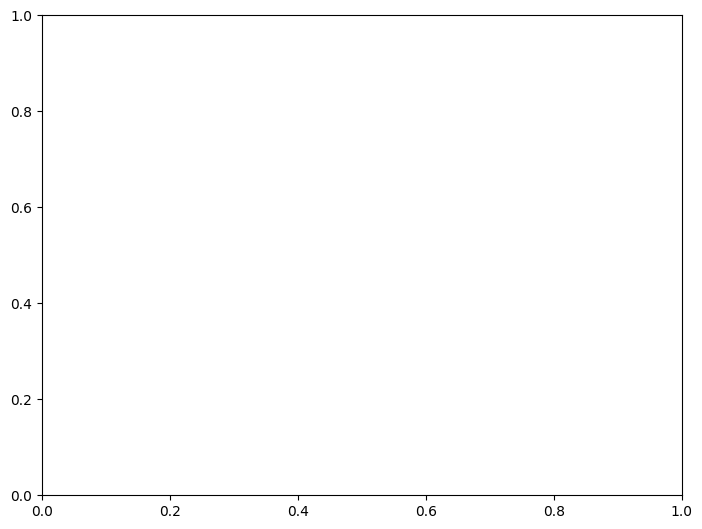

In [137]:
def arredondar(coord, precisao=1):
        """
        Arredonda uma coordenada para reduzir duplicidade de nós.
        """
        
        lat = coord[0] #(coord[0]**expo) / (10 ** reducao)
        lon = coord[1]#(coord[1]**expo) / (1000 ** reducao)
        
        return (round(lat, precisao), round(lon, precisao))
gdf = gpd.read_file("MapaTrechoCidade/MapaTrechoCidadeLine.shp")                            # Lê o shapefile como GeoDataFrame

# Verifica se o sistema de coordenadas está correto (UTM zona 23S)
if gdf.crs.to_epsg() != 31983:
    raise ValueError("O shapefile deve estar no sistema de coordenadas EPSG:31983 (UTM 23S)")

# Remove vias não apropriadas para pedestres (ex: rodovias e vias expressas)
gdf = gdf[~gdf["codigoTipo"].isin([6, 8])].copy()
gdf = gdf.explode().reset_index(drop=True)


gdf["grafo"] = gdf["geometry"].apply(lambda geometry: [arredondar(x) for x in geometry.coords])
ruas_duplicadas = gdf[gdf['grafo'].duplicated(keep=False)]

print(f'Ruas duplicadas: {len(ruas_duplicadas)}')
G = nx.Graph()  # Cria grafo não-direcionado
for index, linha in gdf.iterrows():
    # Extrai as coordenadas das linhas
    coords = list(linha.geometry.coords)
    # Adiciona arestas ao grafo com pesos baseados na distância
  
    for i in range(len(coords) - 1):

        u = linha["grafo"][i]
        v = linha["grafo"][i+1]
        distancia = Point(coords[i]).distance(Point(coords[i + 1]))
        G.add_edge(u, v, distancia=distancia)

componentes = list(nx.connected_components(G))
print(f"Número de componentes conectados: {len(componentes)}")

if nx.is_connected(G):
    print("O grafo está completamente conectado.")
else:
    print("O grafo está fragmentado em mais de um componente.")

cores = list(nx.connected_components(G))
color_map = {}

for i, comp in enumerate(cores):
    for node in comp:
        color_map[node] = i

cores_nos = [color_map[n] for n in G.nodes()]
nx.draw(G, node_color=cores_nos, with_labels=False, node_size=10, cmap=plt.cm.Set1)
plt.show()


In [163]:
def unir_componentes_desconectados(G):
    """
    Une componentes desconectados de um grafo ligando os nós mais próximos entre componentes.
    O grafo deve ter os nós como tuplas de coordenadas (x, y).
    """

    while nx.number_connected_components(G) > 1:
        componentes = list(nx.connected_components(G))
        print(nx.number_connected_components(G))
        # Cria um KDTree para cada componente e guarda os nós
        kdtrees = []
        coord_nos = []
        for comp in componentes:
            nos = list(comp)
            coords = np.array(nos)  # Os nós são as próprias coordenadas
            kdtrees.append(KDTree(coords))
            coord_nos.append(nos)

        # Busca o menor par de nós entre qualquer par de componentes
        menor_dist = float("inf")
        melhor_par = (None, None)

        for i in range(len(componentes)):
            for j in range(i + 1, len(componentes)):
                dists, idxs = kdtrees[i].query(np.array(coord_nos[j]))
                min_idx = np.argmin(dists)
                dist = dists[min_idx]
                if dist < menor_dist:
                    menor_dist = dist
                    no1 = coord_nos[i][idxs[min_idx]]
                    no2 = coord_nos[j][min_idx]
                    melhor_par = (no1, no2)

        # Conecta os dois nós mais próximos entre componentes diferentes
        if melhor_par[0] and melhor_par[1]:
            distancia = Point(melhor_par[0]).distance(Point(melhor_par[1]))
            print(f"Distancia da juntação: {distancia}")
            G.add_edge(melhor_par[0], melhor_par[1], distancia=distancia)
    return G

In [164]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
from shapely.ops import linemerge

# Arredonda coordenadas para evitar duplicidade de nós (ajuste importante)
def arredondar(coord, precisao=5):
    return (round(coord[0], precisao), round(coord[1], precisao))


# Lê o shapefile
gdf = gpd.read_file("MapaTrechoCidade/MapaTrechoCidadeLine.shp")

# Confere o CRS
if gdf.crs.to_epsg() != 31983:
    raise ValueError("O shapefile deve estar no sistema de coordenadas EPSG:31983 (UTM 23S)")

# Remove tipos não caminháveis
gdf = gdf[~gdf["codigoTipo"].isin([6, 8])].copy()

# Explode multilinhas
gdf = gdf.explode(index_parts=False).reset_index(drop=True)

# Remove linhas duplicadas por geometria direta e invertida (reverso também conta)
def hash_linha(coords):
    coords = [arredondar(pt) for pt in coords]
    return tuple(sorted([tuple(coords), tuple(reversed(coords))]))

gdf["grafo"] = gdf["geometry"].apply(lambda geometry: hash_linha(geometry.coords))
ruas_duplicadas = gdf[gdf['grafo'].duplicated(keep=False)]

print(f'Ruas duplicadas: {len(ruas_duplicadas)}')


# Constrói grafo
G = nx.Graph()

for _, linha in gdf.iterrows():
    coords = list(linha.geometry.coords)

    for i in range(len(coords) - 1):
        u = arredondar(coords[i])
        v = arredondar(coords[i + 1])

        distancia = Point(u).distance(Point(v))
        G.add_edge(u, v, distancia=distancia)

print(f"Número de componentes antes da união: {nx.number_connected_components(G)}")
G = unir_componentes_desconectados(G)
print(f"Número de componentes depois da união: {nx.number_connected_components(G)}")


if nx.is_connected(G):
    print("✅ O grafo está completamente conectado.")
else:
    print("❌ O grafo está fragmentado em múltiplos componentes.")




Ruas duplicadas: 24
Número de componentes antes da união: 168
168
Distancia da juntação: 9.999959729611874e-06
167
Distancia da juntação: 9.999959729611874e-06
166
Distancia da juntação: 9.999959729611874e-06
165
Distancia da juntação: 1.0000541806221008e-05
164
Distancia da juntação: 1.414187288057803e-05
163
Distancia da juntação: 2.8284404299914083e-05
162
Distancia da juntação: 3.605559357252844e-05
161
Distancia da juntação: 5.099027518579302e-05
160
Distancia da juntação: 7.999967783689499e-05
159
Distancia da juntação: 0.00010816671614136665
158
Distancia da juntação: 0.00011401761939755343
157
Distancia da juntação: 0.00031890448097369203
156
Distancia da juntação: 0.0003860053715530829
155
Distancia da juntação: 0.0005300941763238531
154
Distancia da juntação: 0.0007900632506872664
153
Distancia da juntação: 0.0008700575856208136
152
Distancia da juntação: 0.0011541224146258695
151
Distancia da juntação: 0.0022865907486046334
150
Distancia da juntação: 0.002408401996666688
149

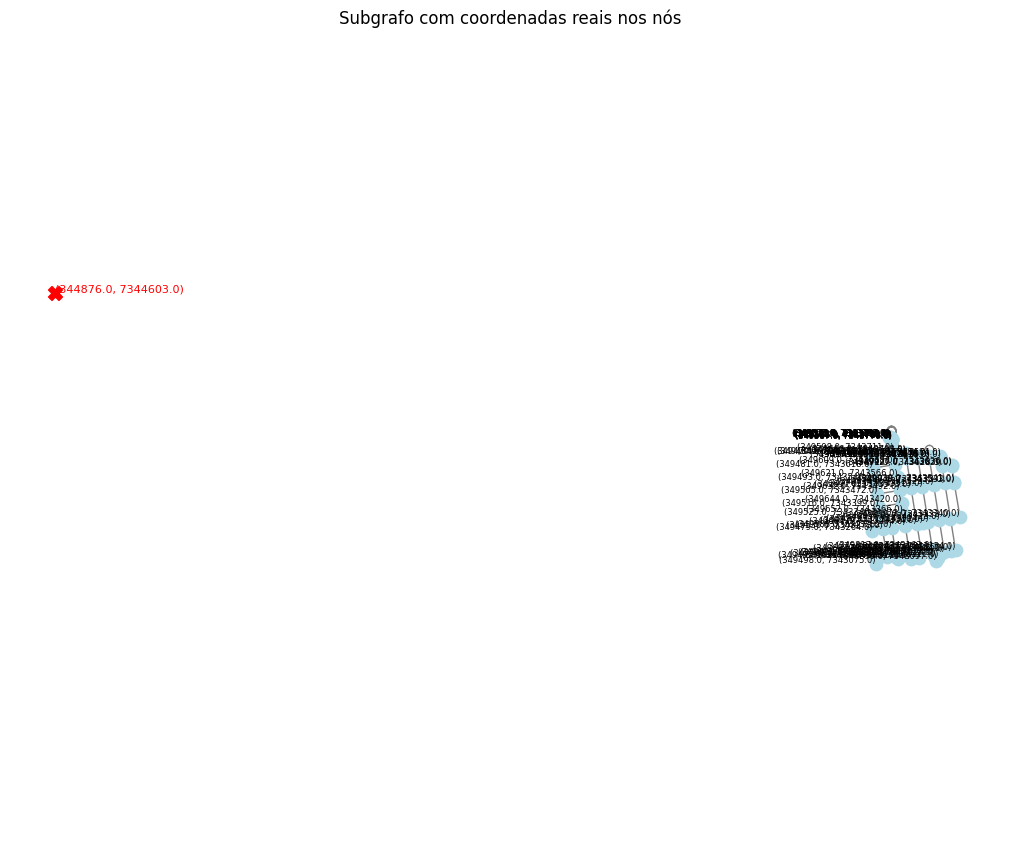

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:4326", "epsg:31983", always_xy=True)


# Define a área de interesse (em metros no EPSG:31983)
x_max, y_max = 349996.7,7343807.3
x_min, y_min = 349432.8,7343061.6

bbox_nodes = [
    node for node in shap.G.nodes
    if x_min <= node[0] <= x_max and y_min <= node[1] <= y_max
]

# Cria subgrafo com esses nós
subgraph = shap.G.subgraph(bbox_nodes)

# Usa os próprios nós como posições
pos = {node: node for node in subgraph.nodes}

# Desenha o grafo
plt.figure(figsize=(10, 8))
nx.draw(subgraph, pos=pos, with_labels=False, node_color='lightblue', edge_color='gray', node_size=80)

# Adiciona rótulos com coordenadas
for node in subgraph.nodes:
    plt.text(node[0], node[1], f"{node}", fontsize=6, ha='right', va='bottom')

lat,lon = -24.002981377415367, -46.525055968117336
x, y = transformer.transform(lon, lat)
# Adiciona o ponto convertido
plt.scatter(x, y, color='red', s=100, marker='X', label='Ponto EPSG:4326 convertido')
plt.text(round(x,0), round(y,0), f"({round(x,0)}, {round(y,0)})", fontsize=8, color='red', ha='left', va='bottom')


plt.title("Subgrafo com coordenadas reais nos nós")
plt.grid(True)
plt.axis('equal')
plt.show()

